# Hosting Capacity Spatial Mapping Models to Support Decision Making

## A Reduced Electrically-Equivalent Model of the IEEE European Low Voltage

### Panda Power

In [1]:
import pandas as pd
import pandapower as pp
import numpy as np
import os, math

data_dir = 'Modified_116_LV_CSV'

load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\re2.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\vitor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python31

<div style="text-align: center;">
    <div style="background-color: white; display: inline-block; padding: 10px;">
        <img src="Modified_116_LV_CSV/Modified 116 LV feeder.png" width="600px">
    </div>
</div>

In [2]:
# Source data
source_df = pd.read_csv(os.path.join(data_dir,'Source.csv'), skiprows=1, sep='=')
source_dict = {i:float(row.iloc[0].split()[0]) for i, row in source_df.iterrows()}
print(source_dict)

source_dict['ISC1'] = source_dict['ISC1'] / 1000
source_dict['ISC3'] = source_dict['ISC3'] / 1000

# Transformer data
trafo_df = pd.read_csv(os.path.join(data_dir,'Transformer.csv'), skiprows=1, sep=';')
trafo_dict = trafo_df.iloc[0].to_dict()
print(trafo_dict)

{'Voltage': 11.0, 'pu': 1.05, 'ISC3': 3000.0, 'ISC1': 5.0}
{'Name': 'TR1', ' phases': 3, ' bus1': 'SourceBus', ' bus2': 1, ' kV_pri': 11, ' kV_sec': 0.416, ' MVA': 0.8, ' Conn_pri': ' Delta', ' Conn_sec': ' Wye', ' %XHL': 4, '% resistance': 0.4}


In [3]:
s_sc_mva = np.sqrt(3) * source_dict['Voltage'] * source_dict['ISC3'] #MVA

net = pp.create_empty_network()

bus_map = {}

hv_bus = pp.create_bus(net, name=trafo_dict[' bus1'], vn_kv=source_dict['Voltage'], type="b")
lv_bus = pp.create_bus(net, name=trafo_dict[' bus2'], vn_kv=trafo_dict[' kV_sec'], type="b")

bus_map[trafo_dict[' bus1']] = hv_bus
bus_map[trafo_dict[' bus2']] = lv_bus

pp.create_ext_grid(net, bus=hv_bus, vm_pu=source_dict['pu'], s_sc_max_mva=s_sc_mva, rx_max=0.1)

pp.create_transformer_from_parameters(
    net=net, hv_bus=hv_bus, lv_bus=lv_bus,
    sn_mva=trafo_dict[' MVA'],
    vn_hv_kv=trafo_dict[' kV_pri'],
    vn_lv_kv=trafo_dict[' kV_sec'],
    vk_percent=trafo_dict[' %XHL'],
    vkr_percent=trafo_dict['% resistance'],
    pfe_kw=0.0, i0_percent=0.0, shift_degree=0.0, 
    name=trafo_dict['Name']
)

0

In [4]:
lines_df = pd.read_excel(os.path.join(data_dir, "Lines.xlsx"), skiprows=1)
# lines_df['Length'] = lines_df['Length'] / 1000 # m to km
lines_df['Units'] = 'km'
lines_df.head()

lineCodes_df = pd.read_csv(os.path.join(data_dir, "LineCodes.csv"), skiprows=1, sep=';')

all_bus_ids = np.unique(lines_df[['Bus1', 'Bus2']].values.ravel('K'))
for id in all_bus_ids:
    id = math.floor(id)
    if id not in bus_map.keys():
        bus = pp.create_bus(net, name=id, vn_kv=trafo_dict[' kV_sec'], type="b")
        bus_map[id] = bus

In [5]:
# Create Loads
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
print(loads_df.head(10))

net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
load_map = {}
for _, row in loads_df.iterrows():
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in bus_map) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW'] / 1000
            qa = row['kW']/1000 * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW'] / 1000
            qb = row['kW']/1000 * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW'] / 1000
            qc = row['kW']/1000 * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=bus_map[bus_id],
            p_a_mw=pa, q_a_mvar=qa,
            p_b_mw=pb, q_b_mvar=qb,
            p_c_mw=pc, q_c_mvar=qc,
            name=row['Name']
        )
        load_map[load] = row['Yearly']

net.asymmetric_load.head(10)

     Name  numPhases   Bus phases    kV  Model Connection  kW    PF    Yearly
0   LOAD1          1   5.0      A  0.23      1        wye   1  0.95   Shape_1
1   LOAD2          1   7.0      B  0.23      1        wye   1  0.95   Shape_2
2   LOAD3          1  10.0      A  0.23      1        wye   1  0.95   Shape_3
3   LOAD4          1  11.0      A  0.23      1        wye   1  0.95   Shape_4
4   LOAD5          1  12.0      A  0.23      1        wye   1  0.95   Shape_5
5   LOAD6          1  13.0      B  0.23      1        wye   1  0.95   Shape_6
6   LOAD7          1  21.0      B  0.23      1        wye   1  0.95   Shape_7
7   LOAD8          1  25.0      C  0.23      1        wye   1  0.95   Shape_8
8   LOAD9          1  26.0      A  0.23      1        wye   1  0.95   Shape_9
9  LOAD10          1  29.2      B  0.23      1        wye   1  0.95  Shape_10


,name,bus,p_a_mw,q_a_mvar,p_b_mw,q_b_mvar,p_c_mw,q_c_mvar,sn_mva,scaling,in_service,type
0,LOAD1,5,0.001,0.000329,0.000,0.000000,0.000,0.000000,NaN,1.0,True,wye
1,LOAD2,7,0.000,0.000000,0.001,0.000329,0.000,0.000000,NaN,1.0,True,wye
2,LOAD3,10,0.001,0.000329,0.000,0.000000,0.000,0.000000,NaN,1.0,True,wye
3,LOAD4,11,0.001,0.000329,0.000,0.000000,0.000,0.000000,NaN,1.0,True,wye
4,LOAD5,12,0.001,0.000329,0.000,0.000000,0.000,0.000000,NaN,1.0,True,wye
5,LOAD6,13,0.000,0.000000,0.001,0.000329,0.000,0.000000,NaN,1.0,True,wye
6,LOAD7,21,0.000,0.000000,0.001,0.000329,0.000,0.000000,NaN,1.0,True,wye
7,LOAD8,25,0.000,0.000000,0.000,0.000000,0.001,0.000329,NaN,1.0,True,wye
8,LOAD9,26,0.001,0.000329,0.000,0.000000,0.000,0.000000,NaN,1.0,True,wye
9,LOAD10,29,0.000,0.000000,0.001,0.000329,0.000,0.000000,NaN,1.0,True,wye


to create a line from parameters `pp.create_line_from_parameters` we must first assign a `max_i_ka` per LineCode.

Here is the Standard Line Parameters for PandaPower:

In [6]:
StdLineCodes_df = pd.read_csv(os.path.join(data_dir, 'StandardLineCodes.csv'), sep=';')
# print(StdLineCodes_df.head())
StdLineCodes_df['max_i_ka'].describe()

count    51.000000
mean      0.432314
std       0.269581
min       0.105000
25%       0.250500
50%       0.350000
75%       0.498000
max       1.150000
Name: max_i_ka, dtype: float64

In [7]:
from sklearn.linear_model import LinearRegression

X = StdLineCodes_df[['r_ohm_per_km', 'x_ohm_per_km', 'c_nf_per_km']]
Y = StdLineCodes_df['max_i_ka']

x_test = lineCodes_df[['Name', 'R1', 'X1', 'C1']].set_index('Name')
x_test.columns = X.columns

model = LinearRegression()
model.fit(X, Y)

coefficients = dict(zip(X.columns, model.coef_))
intercept = model.intercept_

coefficients["intercept"] = intercept
print(coefficients)

y_pred_lr = model.predict(x_test)
print(y_pred_lr)

{'r_ohm_per_km': -0.027992220631350536, 'x_ohm_per_km': -0.862038384077252, 'c_nf_per_km': -0.0013628970743908564, 'intercept': 0.8237539896121313}
[0.71529451 0.71570356 0.72014921 0.74597276 0.75315532 0.76307509
 0.75006473 0.75094965]


In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
x_test_scaled = scaler.fit_transform(x_test)

knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_scaled, Y)

y_pred_knn = knn.predict(x_test_scaled)
print(y_pred_knn)

lineCodes_df['max_i_ka'] = y_pred_knn
lineCodes_df

[0.19    0.19    0.315   0.48425 0.48425 0.48425 0.48425 0.48425]


,Name,nphases,R1,X1,R0,X0,C1,C0,Units,max_i_ka
0,2c_.0225,3,1.257,0.0850,1.257,0.085,0,0,km,0.19000
1,2c_16,3,1.150,0.0880,1.200,0.088,0,0,km,0.19000
2,35_SAC_XSC,3,0.868,0.0920,0.760,0.092,0,0,km,0.31500
3,4c_.06,3,0.469,0.0750,1.581,0.091,0,0,km,0.48425
4,4c_.1,3,0.274,0.0730,0.959,0.079,0,0,km,0.48425
5,4c_.35,3,0.089,0.0675,0.319,0.076,0,0,km,0.48425
6,4c_70,3,0.446,0.0710,1.505,0.083,0,0,km,0.48425
7,4C_95_SAC_XC,3,0.322,0.0740,0.804,0.093,0,0,km,0.48425


In [9]:
# lineCodes_df['max_i_ka'] = y_pred_knn
# lineCodes_df['max_i_ka'] = y_pred_lr
# lineCodes_df['max_i_ka'] = np.ones(len(lineCodes_df))
# lineCodes_df

In [ ]:
full_line_df = lines_df.merge(lineCodes_df, left_on="LineCode", right_on="Name", how="left")
# full_line_df.head(10)

net.line.drop(net.line.index, inplace=True)
for _, line in full_line_df.iterrows():
    # print(line)
    pp.create_line_from_parameters(
        net, from_bus = bus_map[math.floor(line['Bus1'])],
        to_bus = bus_map[math.floor(line['Bus2'])],
        length_km = line['Length'],
        r_ohm_per_km=line["R1"],
        x_ohm_per_km=line["X1"],
        c_nf_per_km=line["C1"],
        max_i_ka=line["max_i_ka"],
        name=line["Name_x"]
    )

net

This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - asymmetric_load (55 elements)
   - ext_grid (1 element)
   - line (115 elements)
   - trafo (1 element)

In [11]:
pp.diagnostic(net)



_____________ PANDAPOWER DIAGNOSTIC TOOL _____________ 


 --------


 --------


 --------


 --------


 --------


 --------

Checking for overload...

Overload check failed: Power flow still does not converge with load and generation scaled down to 0.1 percent.

 --------


 --------

Checking switch configuration...

Power flow still does not converge with all switches closed.

 --------


 --------


 --------


 --------

numba_comparison failed due to the following error:
Power Flow nr did not converge after 10 iterations!

 --------


 --------

_____________ END OF PANDAPOWER DIAGNOSTIC _____________ 


{'overload': {'load': False, 'generation': False},
 'wrong_switch_configuration': False}

use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

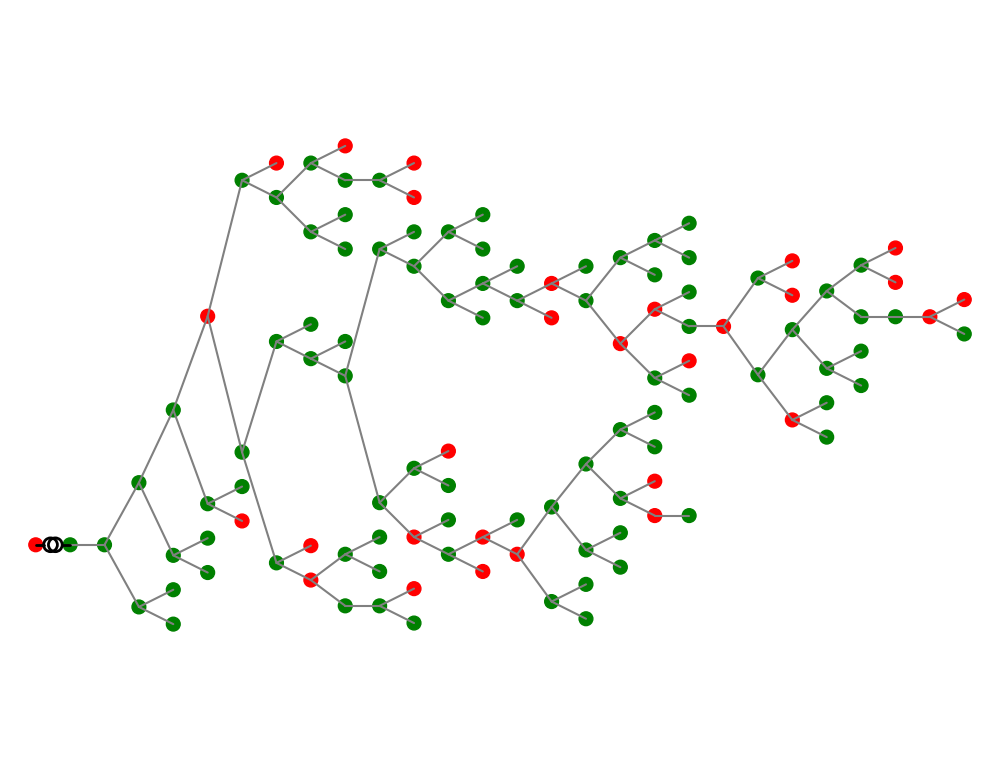

In [59]:
import random
bus_risk = {
    bus: risk for bus, risk in zip(net.bus.index, random.choices(['green', 'red'], [0.8, 0.2], k=len(net.bus)))
}


from pandapower.plotting import simple_plot, cmap_discrete, create_bus_collection, create_line_collection, create_trafo_collection, draw_collections
line_col = create_line_collection(
    net, lines=net.line.index,
    color='grey'
)

trafo_col = create_trafo_collection(
    net, trafos=net.trafo.index,
    color='k', size=0.2
)

bus_col = create_bus_collection(
    net, buses=list(bus_risk.keys()),
    color=[bus_risk[bus] for bus in bus_risk],
    size=0.2
)
draw_collections([bus_col, line_col, trafo_col])

# simple_plot(net, plot_loads=True, bus_color=bus_risk)

In [61]:
pp.runpp_3ph(
    net, init='auto',
    max_iteration=10000,
    tolerance_mva=1e-6,
    v_debug=True)

print(net.res_bus[["vm_pu"]].describe())        # Voltage profile
print(net.res_line[["loading_percent"]].max())  # Worst-case line loading

KeyError: 'x0x_max'

In [ ]:
net.res_bus.to_csv('./results/res_bus.csv')
net.res_line.to_csv('./results/res_line.csv')
net.res_trafo.to_csv('./results/res_trafo.csv')
net.res_ext_grid.to_csv('./results/res_ext_grid.csv')

In [ ]:
loadShapes_df = pd.read_csv(os.path.join(data_dir, "LoadShapes.csv"), skiprows=1, sep=';')
print(loadShapes_df.head(10))

       Name  npts  minterval                 File  useactual
0   Shape_1  1440          1   Load_profile_1.csv       True
1   Shape_2  1440          1   Load_profile_2.csv       True
2   Shape_3  1440          1   Load_profile_3.csv       True
3   Shape_4  1440          1   Load_profile_4.csv       True
4   Shape_5  1440          1   Load_profile_5.csv       True
5   Shape_6  1440          1   Load_profile_6.csv       True
6   Shape_7  1440          1   Load_profile_7.csv       True
7   Shape_8  1440          1   Load_profile_8.csv       True
8   Shape_9  1440          1   Load_profile_9.csv       True
9  Shape_10  1440          1  Load_profile_10.csv       True
